In [ ]:
# $ conda install -c conda-forge boost==1.73.0
# $ conda install -c salilab mkdssp

step 1: Download real_sequence's PDB from alphafold cloud (Done)

step 2: generate DSSP (2 configs) from PDB file of real_sequences (Done)

step 3: generate fasta file for predicted sequences (Done) (refer to alphafold.sh)

step 4: send it to Colab and run Alphafold on predicted sequences (Done)

step 5: generate DSSP (2 configs) from PDB files generated for predicted sequences (Done)

step 6: Run analysis (ss matches, TM scores, etc.) (Done)

# Filter samples and lookup for UniProtKB's PDB (range of Matching Percentage = 50-90%. Length < 1024)

In [1]:
import os
import subprocess
import json
import pandas as pd
in_file = "/home/tlp5359/projects/CC_Sequencing_LLM/BCB/inference-results/KCYM/E-Coli-to-others/UniRef100-F1.json"
out_dir = "pdbs/"
label = 'E-Coli'

output =  pd.read_json(in_file)
output = output[(output['seq_label'] == label) & (output['seq_length']<=1024)]
output.keys()

Index(['seq_label', 'original_20aas', 'original sequence', 'description',
       'seq_length', 'Masking %', 'Matching Percentage',
       'Matching Percentage full', 'full predicted', 'expected', 'predicted',
       'scoreboard'],
      dtype='object')

In [2]:
output = output[(output['Matching Percentage']>= 50) & (output['Matching Percentage']<=90)]
len(output)

891

In [3]:
# Define variables
pdb_id_lst = [ d.split()[0].split('_')[-1] for d in output['description']]
ss1_lst = []
ss2_lst = []
SS_MAP = {
    'H': 'H',
    'B': 'C',
    'E': 'E',
    'G': 'H',
    'I': 'C',
    'T': 'C',
    'S': 'C',
    '-': 'C',
    '*': '*'
}

In [4]:
from Bio.PDB import PDBParser, DSSP
p = PDBParser()

def get_ss(pdb_id,verbose=True):
    pdb_url = f"https://alphafold.ebi.ac.uk/files/AF-{pdb_id}-F1-model_v4.pdb"
    pdb_file = f"{out_dir}/AF-{pdb_id}-F1-model_v4.pdb"

    # Check if the PDB file already exists
    if not os.path.isfile(pdb_file):
        try:
            # Download the PDB file using curl
            subprocess.run(["curl", "-o", pdb_file, pdb_url], check=True, capture_output=True)
            # Check if the file contains an error message
            with open(pdb_file, 'r') as f:
                content = f.read()
                if "NoSuchKey" in content:
                    if verbose:
                        print(f"Not found URL {pdb_url}, returning empty strings")
                    os.remove(pdb_file)
                    return ('','')
                else:
                    if verbose:
                        print("Downloaded ",pdb_url)
        except subprocess.CalledProcessError as e:
            if verbose:
                print(f"Failed to download {pdb_url}. Error: {e}. Return empty strings")
            return ('','')
    elif verbose:
        print(f"{pdb_file} already exists. Skipping download.")
    
    # Run dssp
    structure = p.get_structure(pdb_id, pdb_file)
    model = structure[0]
    dssp = DSSP(model, pdb_file, dssp='mkdssp')

    ss1 = []
    ss2 = []
    for k in dssp.keys():
        c = dssp[k][2]
        ss1.append(c)
        ss2.append(SS_MAP[c])
    return ''.join(ss1), ''.join(ss2)

In [ ]:
for pdb_id in pdb_id_lst:
    a,b = get_ss(pdb_id)
    ss1_lst.append(a)
    ss2_lst.append(b)

In [6]:
# Add new key-value pairs
output['ss1'] = ss1_lst
output['ss2'] = ss2_lst

filtered_output = output[output['ss1']!= '']
print(len(output['ss1']),"-- shrinked to -->", len(filtered_output['ss1']))

filtered_output.to_json(f"{out_dir}/filtered_result.json")


891 -- shrinked to --> 124


In [7]:
filtered_output

,seq_label,original_20aas,original sequence,description,seq_length,Masking %,Matching Percentage,Matching Percentage full,full predicted,expected,predicted,scoreboard,ss1,ss2
1496,E-Coli,MSKPPLFFIVIIGLIIVAASFRFMQQRREKADNDMAPLQQKLVVVS...,MSKPPLFFIVIIGLIIVAASFRFMQQRREKADNDMAPLQQKLVVVS...,UniRef100_A0A0Q2YKV2 DUF2500 domain-containing...,119,85.714286,67.647059,72.268908,MNKPPLFLIVIIGLIIVAASLRFMQQRWEKADNDMAPLQQKLVVTS...,S PPLFFIVIIGLIIVAASFRF QQRRE ADND APLQQ LVVVSN...,N PPLFLIVIIGLIIVAASLRF QQRWE ADND APLQQ LVVTSN...,"[{'N': 0.44928559660911505, 'S': 0.42465558648...",-----HHHHHHHHHHHHHHHHHHHHHHHHHHHHHS---EEEEEEEE...,CCCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCCCEEEEEEEE...
1508,E-Coli,MKLISNDLSDGDKLPHRHVFNGMGYDGDNISPHLAWDDVPVGTKSF...,MKLISNDLSDGDKLPHRHVFNGMGYDGDNISPHLAWDDVPVGTKSF...,UniRef100_B7ULW9 Predicted kinase inhibitor n=...,158,91.139241,86.805556,87.974684,MKLISNDLRDGDKLPHRHVFNGMGYDGDNISPHLAWDDVPAGTKSF...,LISNDLSDGD LPHRHVFNG G DGDNISPHLAWDDVPVGT SFVV...,LISNDLRDGD LPHRHVFNG G DGDNISPHLAWDDVPAGT SFVV...,"[{'L': 0.997111320495605, 'N': 0.0013587021967...",-EEE-SS--TTSB--GGGB-SSTT---------EEEE---TT--EE...,CEEECCCCCCCCCCCHHHCCCCCCCCCCCCCCCEEEECCCCCCCEE...
1522,E-Coli,MARKRKSRNSSKPAHGAISRINRPNNPFAPQRNRYAHKYLTLALMG...,MARKRKSRNSSKPAHGAISRINRPNNPFAPQRNRYAHKYLTLALMG...,UniRef100_A0A7A2W9Z6 DUF1190 domain-containing...,212,84.905660,78.888889,82.075472,MARKRKSRNNTKIGHGAISRIGRPNNPFEPRRNRYAQKYLTLFLMG...,AR R SRNSS PAHGAISRINRPNNPFAPQRNR AH LTLAL GGA...,AR R SRNNT IGHGAISRIGRPNNPFEPRRNR AQ LTLFL GGA...,"[{'A': 0.9915862083435051, 'S': 0.005705136805...",--------------------------TT------------------...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...
1687,E-Coli,MTGKEAIIHYLGTHKKFCAQDVAAVTGATVTSINQAAAKMARAGLL...,MTGKEAIIHYLGTHKKFCAQDVAAVTGATVTSINQAAAKMARAGLL...,UniRef100_A0A2A3WY85 Protein ren n=1 Tax=Esche...,100,81.000000,55.555556,64.000000,MPVKTDIGHYGNAVKKECEDFSPGVGAATNWISDQAAAKMARAGII...,TG EAIIH LGTH F AQDVAAVTGATVTSINQAAA ARAGLLVIE...,PV TDIGH GNAV E EDFSPGVGAATNWISDQAAA ARAGIIVRE...,"[{'P': 0.9008259177207941, 'A': 0.040570523589...",--HHHHHHHHHHH-S-B-HHHHHHHH---HHHHHHHHHHHHHTTSE...,CCHHHHHHHHHHHCCCCCHHHHHHHHCCCHHHHHHHHHHHHHCCCE...
1718,E-Coli,MNTAFALVLTVFLNTGEPVDLVIGIHDSMKECMAAAAEQKIPGNCY...,MNTAFALVLTVFLNTGEPVDLVIGIHDSMKECMAAAAEQKIPGNCY...,UniRef100_A0A7H9LRP9 DUF1482 family protein n=...,67,83.582090,89.285714,91.044776,MNTAFALVLTVFLNTEEPVDSVIGIHVSMKECMAAAAEQKVPGNCY...,NTAFALVLTVFLNTGEPVDLVIGIHDS E AAAAEQ IPGN PVD ...,NTAFALVLTVFLNTEEPVDSVIGIHVS E AAAAEQ VPGN PVD ...,"[{'N': 0.997368693351745, 'G': 0.0017108222236...",----EEEEEEEE-TTS-EEEEEEEEESSHHHHHHHHHHHT---EEE...,CCCCEEEEEEEECCCCCEEEEEEEEECCHHHHHHHHHHHCCCCEEE...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13848,E-Coli,MAVQISGVLKDGAGKPIQNCTIQLKAKRNSTTVLVNTVASENPDEA...,MAVQISGVLKDGAGKPIQNCTIQLKAKRNSTTVLVNTVASENPDEA...,UniRef100_A0A7A0NZB1 Phage tail protein n=1 Ta...,791,89.001264,69.460227,72.819216,MAVQISGVLKDGAGKPIQNCTIQLKAKRNSTTVLVNTVASENPDEA...,AVQISGVL DGAG PIQN TIQL A RNSTTVLVNTVASENPDEAG...,AVQISGVL DGAG PIQN TIQL A RNSTTVLVNTVASENPDEAG...,"[{'A': 0.9996572732925411, 'V': 0.000324553722...",--EEEEEE-B-TTS-B--SEEEEEEE-S--SS--TT-EEEE---TT...,CCEEEEEECCCCCCCCCCCEEEEEEECCCCCCCCCCCEEEECCCCC...
13909,E-Coli,MITHGCYTRTLHKHKLKKTFIMLSAGLGLFFYVNQNSFANGENYFK...,MITHGCYTRTLHKHKLKKTFIMLSAGLGLFFYVNQNSFANGENYFK...,UniRef100_B9VVY9 Intimin n=1 Tax=Escherichia c...,942,86.305732,75.399754,78.768577,MITSGCYTRTRHKHKLKKTFIMLTAGLGLFLYVNQNSFANGENYFK...,ITHG TRTLH H L TFI LSAGLGLFF VNQNSFANGEN F LGS...,ITSG TRTRH H L TFI LTAGLGLFL VNQNSFANGEN F LSS...,"[{'I': 0.993379116058349, 'G': 0.0028586541302...",-----------------------------------------S-SS-...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...
13929,E-Coli,MPTPTIIKTLATHREKPFVSVVTPTWNRGAFLLYLLYMYRYQDYPA...,MPTPTIIKTLATHREKPFVSVVTPTWNRGAFLLYLLYMYRYQDYPA...,UniRef100_A0A193LM41 Plasmid stabilization pro...,814,86.977887,66.384181,70.761671,MPTPTIIKTLNTHREKPFVSVVTPTWNRGAFLPYGLYMYRYQDYPR...,PTPTII TLATHRE PFVSVVTPTWNRGAFL

In [10]:
# STEP 3: generate predicted sequences' fasta file
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

for _, r in filtered_output.iterrows():
    record = SeqRecord(Seq(r['full predicted']),
                            id=r['description'].split()[0],
                            description=r['description'])
    
    with open(f"{out_dir}/predicted_sequences/{record.id}.fasta","w") as ofile:
        SeqIO.write(record, ofile,'fasta')

In [21]:
lst = list(filtered_output.sort_values(by="Matching Percentage",ascending=False)['description'].apply(lambda x: ''.join(x.split()[0].split('_')[1:])))
out_lst = []
for i in lst:
    if not os.path.isdir(f"pdbs/UniRef100_{i}"):
       out_lst.append(f"${{FASTA_DIR}}/UniRef100_{i}.fasta")
print(len(out_lst),'\n\n')

print("FASTA_DIR=/home/tlp5359/projects/CC_Sequencing_LLM/BCB/pdbs/predicted_sequences")
print(','.join(out_lst))

76 


FASTA_DIR=/home/tlp5359/projects/CC_Sequencing_LLM/BCB/pdbs/predicted_sequences
${FASTA_DIR}/UniRef100_A0A376KY01.fasta,${FASTA_DIR}/UniRef100_A0A5F1DTN5.fasta,${FASTA_DIR}/UniRef100_B7M3T9.fasta,${FASTA_DIR}/UniRef100_A0A7H9QSH4.fasta,${FASTA_DIR}/UniRef100_A0A828BSR8.fasta,${FASTA_DIR}/UniRef100_A0A0C2EMU2.fasta,${FASTA_DIR}/UniRef100_A0A0A1A2E9.fasta,${FASTA_DIR}/UniRef100_A0A7H9LYA0.fasta,${FASTA_DIR}/UniRef100_A0A3K3XW99.fasta,${FASTA_DIR}/UniRef100_F4V4A2.fasta,${FASTA_DIR}/UniRef100_A0A3W5XXR7.fasta,${FASTA_DIR}/UniRef100_A0A838AV69.fasta,${FASTA_DIR}/UniRef100_A0A2Z2JDV5.fasta,${FASTA_DIR}/UniRef100_A0A826TFI3.fasta,${FASTA_DIR}/UniRef100_A0A826R8K6.fasta,${FASTA_DIR}/UniRef100_A0A826SGH6.fasta,${FASTA_DIR}/UniRef100_A0A376RNM9.fasta,${FASTA_DIR}/UniRef100_A0A376TK98.fasta,${FASTA_DIR}/UniRef100_A0A0K9T562.fasta,${FASTA_DIR}/UniRef100_A0A2X7G8D6.fasta,${FASTA_DIR}/UniRef100_A0A789MCR5.fasta,${FASTA_DIR}/UniRef100_A0A1M0D635.fasta,${FASTA_DIR}/UniRef100_A0A140JY95.fasta,${

# TMscore analysis

In [1]:
import pandas as pd

df = pd.read_json("pdbs/filtered_result.json")
df['ID'] = df['description'].apply(lambda x: ''.join(x.split()[0].split('_')[1:]))
df

,seq_label,original_20aas,original sequence,description,seq_length,Masking %,Matching Percentage,Matching Percentage full,full predicted,expected,predicted,scoreboard,ss1,ss2,ID
1496,E-Coli,MSKPPLFFIVIIGLIIVAASFRFMQQRREKADNDMAPLQQKLVVVS...,MSKPPLFFIVIIGLIIVAASFRFMQQRREKADNDMAPLQQKLVVVS...,UniRef100_A0A0Q2YKV2 DUF2500 domain-containing...,119,85.714286,67.647059,72.268908,MNKPPLFLIVIIGLIIVAASLRFMQQRWEKADNDMAPLQQKLVVTS...,S PPLFFIVIIGLIIVAASFRF QQRRE ADND APLQQ LVVVSN...,N PPLFLIVIIGLIIVAASLRF QQRWE ADND APLQQ LVVTSN...,"[{'N': 0.4492855966, 'S': 0.4246555865, 'T': 0...",-----HHHHHHHHHHHHHHHHHHHHHHHHHHHHHS---EEEEEEEE...,CCCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCCCEEEEEEEE...,A0A0Q2YKV2
1508,E-Coli,MKLISNDLSDGDKLPHRHVFNGMGYDGDNISPHLAWDDVPVGTKSF...,MKLISNDLSDGDKLPHRHVFNGMGYDGDNISPHLAWDDVPVGTKSF...,UniRef100_B7ULW9 Predicted kinase inhibitor n=...,158,91.139241,86.805556,87.974684,MKLISNDLRDGDKLPHRHVFNGMGYDGDNISPHLAWDDVPAGTKSF...,LISNDLSDGD LPHRHVFNG G DGDNISPHLAWDDVPVGT SFVV...,LISNDLRDGD LPHRHVFNG G DGDNISPHLAWDDVPAGT SFVV...,"[{'L': 0.9971113205000001, 'N': 0.001358702200...",-EEE-SS--TTSB--GGGB-SSTT---------EEEE---TT--EE...,CEEECCCCCCCCCCCHHHCCCCCCCCCCCCCCCEEEECCCCCCCEE...,B7ULW9
1522,E-Coli,MARKRKSRNSSKPAHGAISRINRPNNPFAPQRNRYAHKYLTLALMG...,MARKRKSRNSSKPAHGAISRINRPNNPFAPQRNRYAHKYLTLALMG...,UniRef100_A0A7A2W9Z6 DUF1190 domain-containing...,212,84.905660,78.888889,82.075472,MARKRKSRNNTKIGHGAISRIGRPNNPFEPRRNRYAQKYLTLFLMG...,AR R SRNSS PAHGAISRINRPNNPFAPQRNR AH LTLAL GGA...,AR R SRNNT IGHGAISRIGRPNNPFEPRRNR AQ LTLFL GGA...,"[{'A': 0.9915862083, 'S': 0.0057051368, 'T': 0...",--------------------------TT------------------...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,A0A7A2W9Z6
1687,E-Coli,MTGKEAIIHYLGTHKKFCAQDVAAVTGATVTSINQAAAKMARAGLL...,MTGKEAIIHYLGTHKKFCAQDVAAVTGATVTSINQAAAKMARAGLL...,UniRef100_A0A2A3WY85 Protein ren n=1 Tax=Esche...,100,81.000000,55.555556,64.000000,MPVKTDIGHYGNAVKKECEDFSPGVGAATNWISDQAAAKMARAGII...,TG EAIIH LGTH F AQDVAAVTGATVTSINQAAA ARAGLLVIE...,PV TDIGH GNAV E EDFSPGVGAATNWISDQAAA ARAGIIVRE...,"[{'P': 0.9008259177, 'A': 0.0405705236, 'T': 0...",--HHHHHHHHHHH-S-B-HHHHHHHH---HHHHHHHHHHHHHTTSE...,CCHHHHHHHHHHHCCCCCHHHHHHHHCCCHHHHHHHHHHHHHCCCE...,A0A2A3WY85
1718,E-Coli,MNTAFALVLTVFLNTGEPVDLVIGIHDSMKECMAAAAEQKIPGNCY...,MNTAFALVLTVFLNTGEPVDLVIGIHDSMKECMAAAAEQKIPGNCY...,UniRef100_A0A7H9LRP9 DUF1482 family protein n=...,67,83.582090,89.285714,91.044776,MNTAFALVLTVFLNTEEPVDSVIGIHVSMKECMAAAAEQKVPGNCY...,NTAFALVLTVFLNTGEPVDLVIGIHDS E AAAAEQ IPGN PVD ...,NTAFALVLTVFLNTEEPVDSVIGIHVS E AAAAEQ VPGN PVD ...,"[{'N': 0.9973686934, 'G': 0.001710822200000000...",----EEEEEEEE-TTS-EEEEEEEEESSHHHHHHHHHHHT---EEE...,CCCCEEEEEEEECCCCCEEEEEEEEECCHHHHHHHHHHHCCCCEEE...,A0A7H9LRP9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13848,E-Coli,MAVQISGVLKDGAGKPIQNCTIQLKAKRNSTTVLVNTVASENPDEA...,MAVQISGVLKDGAGKPIQNCTIQLKAKRNSTTVLVNTVASENPDEA...,UniRef100_A0A7A0NZB1 Phage tail protein n=1 Ta...,791,89.001264,69.460227,72.819216,MAVQISGVLKDGAGKPIQNCTIQLKAKRNSTTVLVNTVASENPDEA...,AVQISGVL DGAG PIQN TIQL A RNSTTVLVNTVASENPDEAG...,AVQISGVL DGAG PIQN TIQL A RNSTTVLVNTVASENPDEAG...,"[{'A': 0.9996572733, 'V': 0.0003245537, 'T': 1...",--EEEEEE-B-TTS-B--SEEEEEEE-S--SS--TT-EEEE---TT...,CCEEEEEECCCCCCCCCCCEEEEEEECCCCCCCCCCCEEEECCCCC...,A0A7A0NZB1
13909,E-Coli,MITHGCYTRTLHKHKLKKTFIMLSAGLGLFFYVNQNSFANGENYFK...,MITHGCYTRTLHKHKLKKTFIMLSAGLGLFFYVNQNSFANGENYFK...,UniRef100_B9VVY9 Intimin n=1 Tax=Escherichia c...,942,86.305732,75.399754,78.768577,MITSGCYTRTRHKHKLKKTFIMLTAGLGLFLYVNQNSFANGENYFK...,ITHG TRTLH H L TFI LSAGLGLFF VNQNSFANGEN F LGS...,ITSG TRTRH H L TFI LTAGLGLFL VNQNSFANGEN F LSS...,"[{'I': 0.9933791161000001, 'G': 0.0028586541, ...",-----------------------------------------S-SS-...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,B9VVY9
13929,E-Coli,MPTPTIIKTLATHREKPFVSVVTPTWNRGAFLLYLLYMYRYQDYPA...,MPTPTIIKTLATHREKPFVSVVTPTWNRGAFLLYLLYMYRYQDYPA...,UniRef100_A0A193LM41 Plasmid stabilization pro...,814,86.977887,66.384181,70.761671,MPTPT

## TM-score generation and display pyMol render

You need to generate AlphaFold structure for the predicted sequences before doing comparisons with TM-score.

See **alphafold.sh** for docker's execution used. (Refer to alphafold's github for installation and instructions)

In [2]:
import subprocess
import re
import os

def parse_tmscore_output(pdb1_path, pdb2_path):
    # Check if pdb paths exist
    if not os.path.exists(pdb1_path):
        print(f"The file {pdb1_path} does not exist.")
        return None, None, None, None, None
    if not os.path.exists(pdb2_path):
        print(f"The file {pdb2_path} does not exist.")
        return None, None, None, None, None
    
    # Execute TMscore process
    result = subprocess.run(['./TMscore', pdb1_path, pdb2_path], capture_output=True, text=True)
    
    # Get the output
    content = result.stdout

    # Extract TM-score
    tm_score_match = re.search(r'TM-score\s+=\s+([\d.]+)\s+\(d0= ', content)
    if tm_score_match:
        tm_score = float(tm_score_match.group(1))
    else:
        tm_score = None

    # Extract rotation matrix
    rotation_matrix_match = re.search(
        r'-------- rotation matrix to rotate Chain-1 to Chain-2 ------\s+i\s+t\(i\)\s+u\(i,1\)\s+u\(i,2\)\s+u\(i,3\)(.*?)\n\n', 
        content, 
        re.DOTALL
    )
    if rotation_matrix_match:
        rotation_matrix_section = rotation_matrix_match.group(1).strip().split('\n')
        rotation_matrix = [list(map(float, line.split()[1:])) for line in rotation_matrix_section]
    else:
        rotation_matrix = None

    # Extract alignments
    alignment1, alignment2, alignment3 = content.split('\n')[-6:-3]
    
    return tm_score, rotation_matrix, alignment1, alignment2, alignment3

def convert_2_colored_latex(alignment1, alignment2, alignment3, black_chars = {'K', 'C', 'Y', 'M'}, chunk_size=100, supchunk = 10):
    def chunk_string(string, chunk_size):
        return [string[i:i+chunk_size] for i in range(0, len(string), chunk_size)]
    
    alignment1_chunks = chunk_string(alignment1, chunk_size)
    alignment2_chunks = chunk_string(alignment2, chunk_size)
    alignment3_chunks = chunk_string(alignment3, chunk_size)
    
    content = "{\n" + r'\begin{spacing}{0.5}' + "\n" + r'\ttfamily' + "\n" + r'\fontsize{6.5}{11}\selectfont' + "\n"
    
    for chunk1, chunk2, chunk3 in zip(alignment1_chunks, alignment2_chunks, alignment3_chunks):
        # Write Alignment 1
        for i, (char1, char3) in enumerate(zip(chunk1, chunk3)):
            if i % supchunk == supchunk -1:
                c = char1 + '\ '
            else:
                c = char1
            if char1 in black_chars:
                content += r'\textcolor{black}{' + c + '}'
            elif char1 == char3:
                content+= r'\textcolor{green}{' + c + '}'
            else:
                content += r'\textcolor{red}{' + c + '}'
        content += (r'\\' + '\n')
        
        # Write Alignment 2
        for i,char2 in enumerate(chunk2):
            if char2 == ' ':
                c = '\ '
            else:
                c = char2
            if i % supchunk == supchunk -1:
                cc = c + '\ '
            else:
                cc = c
            content+= r'\textcolor{black}{' + cc + '}'
        content+= (r'\\' + '\n')

        # Write Alignment 3
        for i, (char1, char3) in enumerate(zip(chunk1, chunk3)):
            if i % supchunk == supchunk -1:
                c = char3 + '\ '
            else:
                c = char3
            if char3 in black_chars:
                content+= (r'\textcolor{black}{' + c + '}')
            elif char1 == char3:
                content += (r'\textcolor{green}{' + c + '}')
            else:
                content += (r'\textcolor{red}{' + c + '}')
        
        content+= (r'\\' + '\n')
        content +=(r'\\' + '\n')
    content += (r'\end{spacing}' + '\n' + '}')
    return content 

import py3Dmol
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import base64
from io import BytesIO
def display_pymol(ppdb_path,opdb_path,rotation_matrix):
    # Load the monomers (assuming monomer1.pdb and monomer2.pdb are the filenames)
    pdb1 = None
    with open(ppdb_path, 'r') as file:
        pdb1 = file.read()
    pdb2 = None
    with open(opdb_path, 'r') as file:
        pdb2 = file.read()

    # Parse PDB and apply rotation to the first structure
    def rotate_structure(pdb_str, rotation_matrix):
        lines = pdb_str.splitlines()
        rotated_pdb = ""
        for line in lines:
            if line.startswith("ATOM"):
                x = float(line[30:38].strip())
                y = float(line[38:46].strip())
                z = float(line[46:54].strip())
                
                xx = rotation_matrix[0][0] + x*rotation_matrix[0][1] + y*rotation_matrix[0][2] + z*rotation_matrix[0][3]
                yy = rotation_matrix[1][0] + x*rotation_matrix[1][1] + y*rotation_matrix[1][2] + z*rotation_matrix[1][3]
                zz = rotation_matrix[2][0] + x*rotation_matrix[2][1] + y*rotation_matrix[2][2] + z*rotation_matrix[2][3]
                
                new_line = (
                    line[:30] +
                    f"{xx:8.3f}{yy:8.3f}{zz:8.3f}" +
                    line[54:]
                )
                rotated_pdb += new_line + "\n"
            else:
                rotated_pdb += line + "\n"
        return rotated_pdb

    PLDDT_BANDS = [(0, 50, '#FF7D45'),
                    (50, 70, '#FFDB13'),
                    (70, 90, '#65CBF3'),
                    (90, 100, '#0053D6')]


    def overwrite_bfactor(pdb_str, bands = PLDDT_BANDS):
        lines = pdb_str.splitlines()
        new_pdb = ""
        for line in lines:
            if line.startswith("ATOM"):
                c = float(line[60:66].strip())
                for i,bands in enumerate(PLDDT_BANDS):
                    if bands[0] <= c < bands[1]: 
                        cc = i
                    else:
                        continue
                new_line = (
                        line[:60] + f"{cc:6.2f}" + line[66:]
                    )
                new_pdb += new_line + "\n"
            else:
                new_pdb += line + "\n"
        return new_pdb

    rotated_pdb1 = rotate_structure(pdb1, rotation_matrix)
    view_pdb1 = overwrite_bfactor(rotated_pdb1)
    view_pdb2 = overwrite_bfactor(pdb2)

    cmap = {i: bands[2] for i, bands in enumerate(PLDDT_BANDS)}

    # Function to create an HTML block for each view
    def create_view_html(view):
        return view._make_html()

    def plot_plddt_legend():
        """Plots the legend for pLDDT."""
        thresh = ['Very low (pLDDT < 50)',
                'Low (70 > pLDDT > 50)',
                'Confident (90 > pLDDT > 70)',
                'Very high (pLDDT > 90)']

        colors = ['#FF7D45', '#FFDB13', '#65CBF3', '#0053D6']

        plt.figure(figsize=(2, 2))
        for c in colors:
            plt.bar(0, 0, color=c)
        plt.legend(thresh, frameon=False, loc='center', fontsize=10)
        plt.xticks([])
        plt.yticks([])
        ax = plt.gca()
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        plt.title('Model Confidence', fontsize=10, pad=20)
        
        buf = BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight')
        buf.seek(0)
        image_base64 = base64.b64encode(buf.read()).decode('utf-8')
        buf.close()
        
        return f'<img src="data:image/png;base64,{image_base64}" />'

    # Create the first view (both models)
    view1 = py3Dmol.view(  width=400, height=400)
    view1.addModel(view_pdb1, 'pdb')  # Replace with your model data
    view1.setStyle({'model': 0}, {'cartoon': {'color': 'blue'}})
    view1.addModel(view_pdb2, 'pdb')  # Replace with your model data
    view1.setStyle({'model': 1}, {'cartoon': {'color': '#11ff10'}})
    view1.zoomTo()

    # Create the second view (only model 1)
    view2 = py3Dmol.view(  width=400, height=400)
    view2.addModel(view_pdb1, 'pdb')  # Replace with your model data
    view2.setStyle({'model': 0}, {'cartoon': {'colorscheme': {'prop': 'b', 'map': cmap}}})
    view2.zoomTo()

    # Create the third view (only model 2)
    view3 = py3Dmol.view(  width=400, height=400)
    view3.addModel(view_pdb2, 'pdb')  # Replace with your model data
    view3.setStyle({'model': 0}, {'cartoon': {'colorscheme': {'prop': 'b', 'map': cmap}}})
    view3.zoomTo()

    # Combine the HTML for the three views
    combined_html = f"""
    <div style="display: flex; justify-content: space-around;">
        <div>{create_view_html(view1)}</div>
        <div>{create_view_html(view2)}</div>
        <div>{create_view_html(view3)}</div>
        <div>{plot_plddt_legend()}</div>
    </div>
    """

    # Display the combined HTML
    display(HTML(combined_html))


Button(description='Next', style=ButtonStyle())

Button(description='Reset', style=ButtonStyle())

Output()

Output()

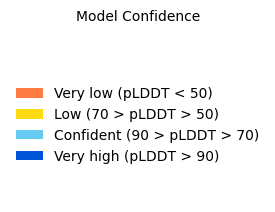

In [74]:
from IPython.display import display
import ipywidgets as widgets

def create_next_button(df, index=0):
    next_button = widgets.Button(description="Next")
    reset_button = widgets.Button(description="Reset")
    output = widgets.Output()
    
    def on_next_button_clicked(b):
        output.clear_output()
        with output:
            if index < len(df) - 1:
                r = df.iloc[index]
                _generate(r)
                next_index = index + 1
                display(create_next_button(df, next_index))  # Display a new button for the next step
            else:
                print("Finished. No more row in df")  
    def on_reset_button_clicked(b):
        output.clear_output()
        with output:
            r = df.iloc[index]
            _generate(r)
            display(create_next_button(df, index))  # Display a new button with reset index

    def _generate(r):
        print("Next: Working on ",index,": ", r['ID'])
        
        pPDB = f"/home/tlp5359/projects/CC_Sequencing_LLM/BCB/pdbs/UniRef100_{r['ID']}/selected_prediction.pdb"
        oPDB = f"/home/tlp5359/projects/CC_Sequencing_LLM/BCB/pdbs/AF-{r['ID']}-F1-model_v4.pdb"
        if not os.path.exists(pPDB):
            for model_i in [1,2,3,4,5]:
                alter_path=f"/home/tlp5359/projects/CC_Sequencing_LLM/BCB/pdbs/new_ones/UniRef100_{r['ID']}/relaxed_model_{model_i}_pred_0.pdb"
                if os.path.exists(alter_path):
                    # print("AHA! ",r["ID"],pPDB)
                    pPDB = alter_path
        
        outContent = ""
        # Parse the file and get the results
        tm_score, rotation_matrix, alignment1, alignment2, alignment3 = parse_tmscore_output(pPDB, oPDB)
        
        if tm_score is not None:
            # Print the extracted information
            outContent += f"\n\nID = {r['ID']}\n\n"
            d = re.sub('_','\_',' '.join(r['description'].split()[1:]))
            outContent += f"\n\nDescription = {d}\n\n"
            outContent += f"Length = {r['seq_length']} (aa)\n\n"
            c1, c2 = sum([1 if a == b else 0 for a, b in zip(r['predicted'], r['expected']) if a != ' ']), sum([1 for a in r['predicted'] if a != ' '])
            outContent += f"Predicted matches = {c1} / {c2} ({c1 * 100 / c2:.2f}\%)\n\n"
            outContent += f"TM-score = {tm_score}\n\n"
            outContent += f"Superposition in the TM-score: Length(d<5.0)= {len(re.sub(' ', '', alignment2))}\n\n"
            outContent += r"\begin{figure}[h]" + '\n' + r"\centering" + '\n' + r"\includegraphics[width=\textwidth]" 
            outContent += f"{{Alphafold/{r['ID']}.png}}" + '\n' 
            outContent += r"\caption{Left: AlphaFold structures of predicted sequence (blue) and of UniProtKB (green). Center: AlphaFold structure of predicted sequence. Right: AlphaFold structure of UniProtKB sequence.}" + '\n' 
            outContent += r"\end{figure}"  + '\n\n'
            outContent += f"Alignment between predicted sequences and UniProtLB sequence:\n {convert_2_colored_latex(alignment1, alignment2, alignment3, black_chars='KCYM', chunk_size=110, supchunk=10)}"
            outContent += '\n\n\hrule\n'
            with open(f"/home/tlp5359/projects/CC_Sequencing_LLM/BCB/Alphafold-result/{r['ID']}.tex", 'w') as ofile:
                ofile.write(outContent)
            
            # Generate display
            display_pymol(pPDB, oPDB, rotation_matrix)
        else:
            print(f"No TMscore generated for {r['ID']}. skipping~")
        
    next_button.on_click(on_next_button_clicked)
    reset_button.on_click(on_reset_button_clicked)
    display(next_button, reset_button, output)
    
# Display the initial views and the "Next" button
chosen_df = df[df['ID'].isin(["A0A7H9QJ10"])]#,"A0A788Y284","A0A0K4ISP7"])]
create_next_button(chosen_df, index=-1) # "Reset button is a bit buggy :)"

In [ ]:
# # fixing some stuff inside latex files:
# for index, r in df.iterrows():
#   print("Next: Working on ",index,": ", r['ID'])
        
#   pPDB = f"/home/tlp5359/projects/CC_Sequencing_LLM/BCB/pdbs/UniRef100_{r['ID']}/selected_prediction.pdb"
#   oPDB = f"/home/tlp5359/projects/CC_Sequencing_LLM/BCB/pdbs/AF-{r['ID']}-F1-model_v4.pdb"
#   if not os.path.exists(pPDB):
#     for model_i in [1,2,3,4,5]:
#       alter_path=f"/home/tlp5359/projects/CC_Sequencing_LLM/BCB/pdbs/new_ones/UniRef100_{r['ID']}/relaxed_model_{model_i}_pred_0.pdb"
#       if os.path.exists(alter_path):
#         pPDB = alter_path

#   outContent = ""
#   # Parse the file and get the results
#   tm_score, rotation_matrix, alignment1, alignment2, alignment3 = parse_tmscore_output(pPDB, oPDB)
  
#   if tm_score is not None:
#       # Print the extracted information
#       outContent += f"\n\nID = {r['ID']}\n\n"
#       d = re.sub('_','\_',' '.join(r['description'].split()[1:]))
#       outContent += f"\n\nDescription = {d}\n\n"
#       outContent += f"Length = {r['seq_length']} (aa)\n\n"
#       c1, c2 = sum([1 if a == b else 0 for a, b in zip(r['predicted'], r['expected']) if a != ' ']), sum([1 for a in r['predicted'] if a != ' '])
#       outContent += f"Predicted matches = {c1} / {c2} ({c1 * 100 / c2:.2f}\%)\n\n"
#       outContent += f"TM-score = {tm_score}\n\n"
#       outContent += f"Superposition in the TM-score (d<5.0)= {len(re.sub(' ', '', alignment2))}\n\n"
#       outContent += r"\includegraphics[width=\textwidth]" + f"{{Alphafold/{r['ID']}.png}}" + '\n' 
#       outContent += r"\textbf{Left:} AlphaFold structures of predicted sequence (blue) and of UniProtKB (green). \textbf{Center:} AlphaFold structure of predicted sequence. \textbf{Right:} AlphaFold structure of UniProtKB sequence." + r"\\\\" + '\n' 
#       outContent += r"Alignment between predicted sequences and UniProtLB sequence:\\\\" + f"\n {convert_2_colored_latex(alignment1, alignment2, alignment3, black_chars='KCYM', chunk_size=110, supchunk=10)}"
#       outContent += '\n\n\hrule\n'
#       with open(f"/home/tlp5359/projects/CC_Sequencing_LLM/BCB/Alphafold-result/{r['ID']}.tex", 'w') as ofile:
#           ofile.write(outContent)

## Get TMscore from generated result 

In [4]:
import os, re
tmscore = {}
pattern = r'TM-score = ([\d\.]+)'

files_and_dirs = os.listdir("Alphafold-result")
files = [os.path.join("Alphafold-result", f) for f in files_and_dirs if f.split('.')[-1] == 'tex' and os.path.isfile(os.path.join("Alphafold-result", f))]
for f in files:
  id = f.split('.')[0].split('/')[-1]
  with open(f,'r') as file:
    content = file.read()
  match = re.search(pattern, content)
  tmscore[id] = float(match.group(1))

tmp_df = df[df['ID'].isin(list(tmscore.keys()))].copy()
tmp_df['TMscore'] = tmp_df['ID'].apply(lambda x: tmscore[x])
print(len(tmp_df))

124


## DSSP Matches


In [ ]:
from Bio.PDB import PDBParser, DSSP
p = PDBParser()
# Define variables
pss1_lst = []
pss2_lst = []
SS_MAP = {
    'H': 'H',
    'B': 'C',
    'E': 'E',
    'G': 'H',
    'I': 'C',
    'T': 'C',
    'S': 'C',
    '-': 'C',
    '*': '*'
}
for pdb_id in list(tmp_df['ID']):
    pdb_file = f"/home/tlp5359/projects/CC_Sequencing_LLM/BCB/pdbs/UniRef100_{pdb_id}/selected_prediction.pdb"
    if not os.path.exists(pdb_file):
        for model_i in [1,2,3,4,5]:
            alter_path=f"/home/tlp5359/projects/CC_Sequencing_LLM/BCB/pdbs/new_ones/UniRef100_{pdb_id}/relaxed_model_{model_i}_pred_0.pdb"
            if os.path.exists(alter_path):
                pdb_file = alter_path
                
    structure = p.get_structure(pdb_id, pdb_file)
    model = structure[0]
    dssp = DSSP(model, pdb_file, dssp='mkdssp')

    ss1 = []
    ss2 = []
    for k in dssp.keys():
        c = dssp[k][2]
        ss1.append(c)
        ss2.append(SS_MAP[c])
    pss1_lst.append(''.join(ss1))
    pss2_lst.append(''.join(ss2))
tmp_df['pss1'] = pss1_lst
tmp_df['pss2'] = pss2_lst

In [7]:
ss1_matches = []
ss2_matches = []
for _, row in tmp_df.iterrows():
  ss1_matches.append(sum([1 if a==b else 0 for a,b in zip(row['ss1'],row['pss1'])])*100/len(row['ss1']))
  ss2_matches.append(sum([1 if a==b else 0 for a,b in zip(row['ss2'],row['pss2'])])*100/len(row['ss2']))

tmp_df['ss1 %'] = ss1_matches
tmp_df['ss2 %'] = ss2_matches


In [ ]:
import subprocess
import json
import os

os.environ['OST_COMPOUNDS_CHEMLIB'] = os.path.expanduser('~/.installations/openstructure/compounds.chemlib')

lddt_dict = {}
bb_lddt_dict = {}
for pdb_id in tmp_df['ID']:
  pdb_file = f"/home/tlp5359/projects/CC_Sequencing_LLM/BCB/pdbs/UniRef100_{pdb_id}/selected_prediction.pdb"
  if not os.path.exists(pdb_file):
    for model_i in [1,2,3,4,5]:
      print("AHA! ",pdb_id)
      alter_path=f"/home/tlp5359/projects/CC_Sequencing_LLM/BCB/pdbs/new_ones/UniRef100_{pdb_id}/relaxed_model_{model_i}_pred_0.pdb"
      if os.path.exists(alter_path):
        pdb_file = alter_path
        
  command = f"ost compare-structures -m {pdb_file} -r pdbs/AF-{pdb_id}-F1-model_v4.pdb --bb-lddt --lddt"
  subprocess.run(command, shell=True, check=True)
  with open("out.json", "r") as file:
    data = json.load(file)
  lddt_dict[pdb_id] = data.get("lddt")
  bb_lddt_dict[pdb_id] = data.get("bb_lddt")

tmp_df["LDDT"] = tmp_df['ID'].apply(lambda x: lddt_dict[x])
tmp_df["BB-LDDT"] = tmp_df['ID'].apply(lambda x: bb_lddt_dict[x])

In [23]:
tmp_df.to_json(f"full_structure_result.json")

# VISUALIZATION

In [1]:
import pandas as pd

tmp_df = pd.read_json(f"full_structure_result.json")

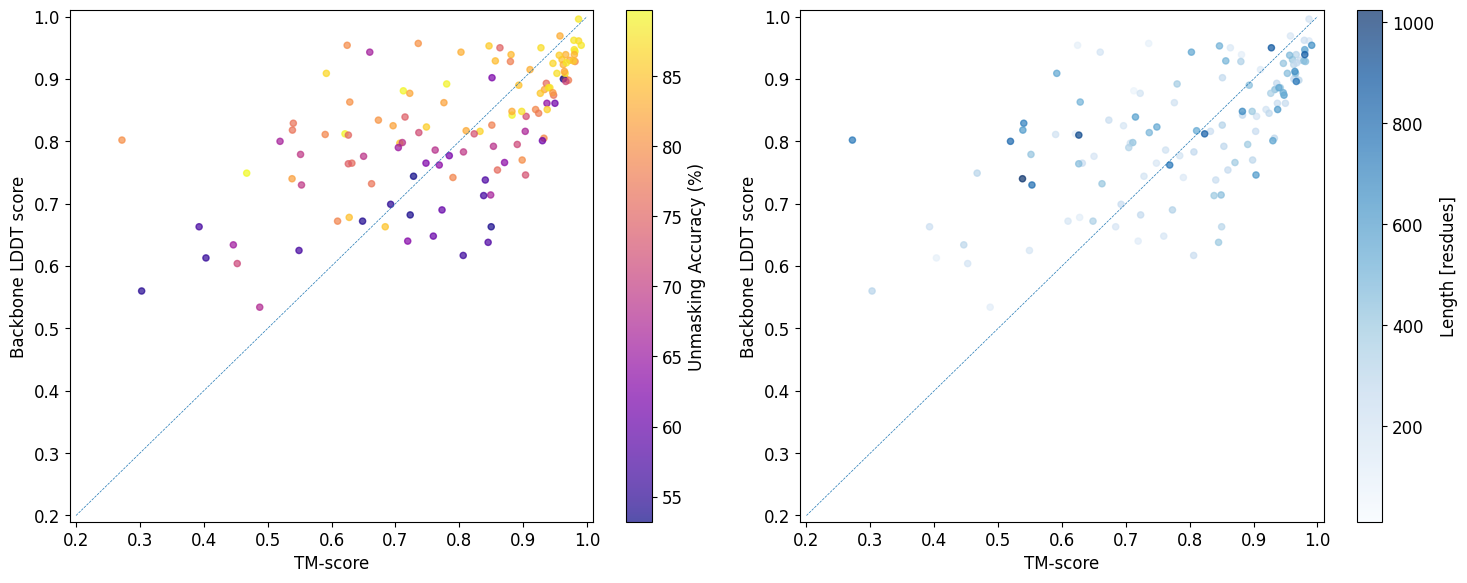

In [62]:
import matplotlib.pyplot as plt
import numpy as np

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

_,[ax1,ax2] = plt.subplots(1,2,figsize=(15,6))
ax1.plot([0.2,1], [0.2,1], linewidth=0.5, linestyle='--')
im1 = ax1.scatter(tmp_df['TMscore'], tmp_df['BB-LDDT'], c=tmp_df['Matching Percentage'], alpha=0.7, cmap='plasma',s=20)
cbar1 = plt.colorbar(im1, ax=ax1)
cbar1.set_label("Unmasking Accuracy (%)")
ax1.set_xlim([0.19,1.01])
ax1.set_ylim([0.19,1.01])
ax1.set_xlabel("TM-score")
ax1.set_ylabel("Backbone LDDT score")

ax2.plot([0.2,1], [0.2,1], linewidth=0.5, linestyle='--')
im2 = ax2.scatter(tmp_df['TMscore'], tmp_df['BB-LDDT'], c=tmp_df['seq_length'], alpha=0.7, cmap='Blues',s=20, vmin=11)
cbar2 = plt.colorbar(im2, ax=ax2)
cbar2.set_label("Length [resdues]")
ax2.set_xlim([0.19,1.01])
ax2.set_ylim([0.19,1.01])
ax2.set_xlabel("TM-score")
ax2.set_ylabel("Backbone LDDT score")
plt.tight_layout()
plt.show()


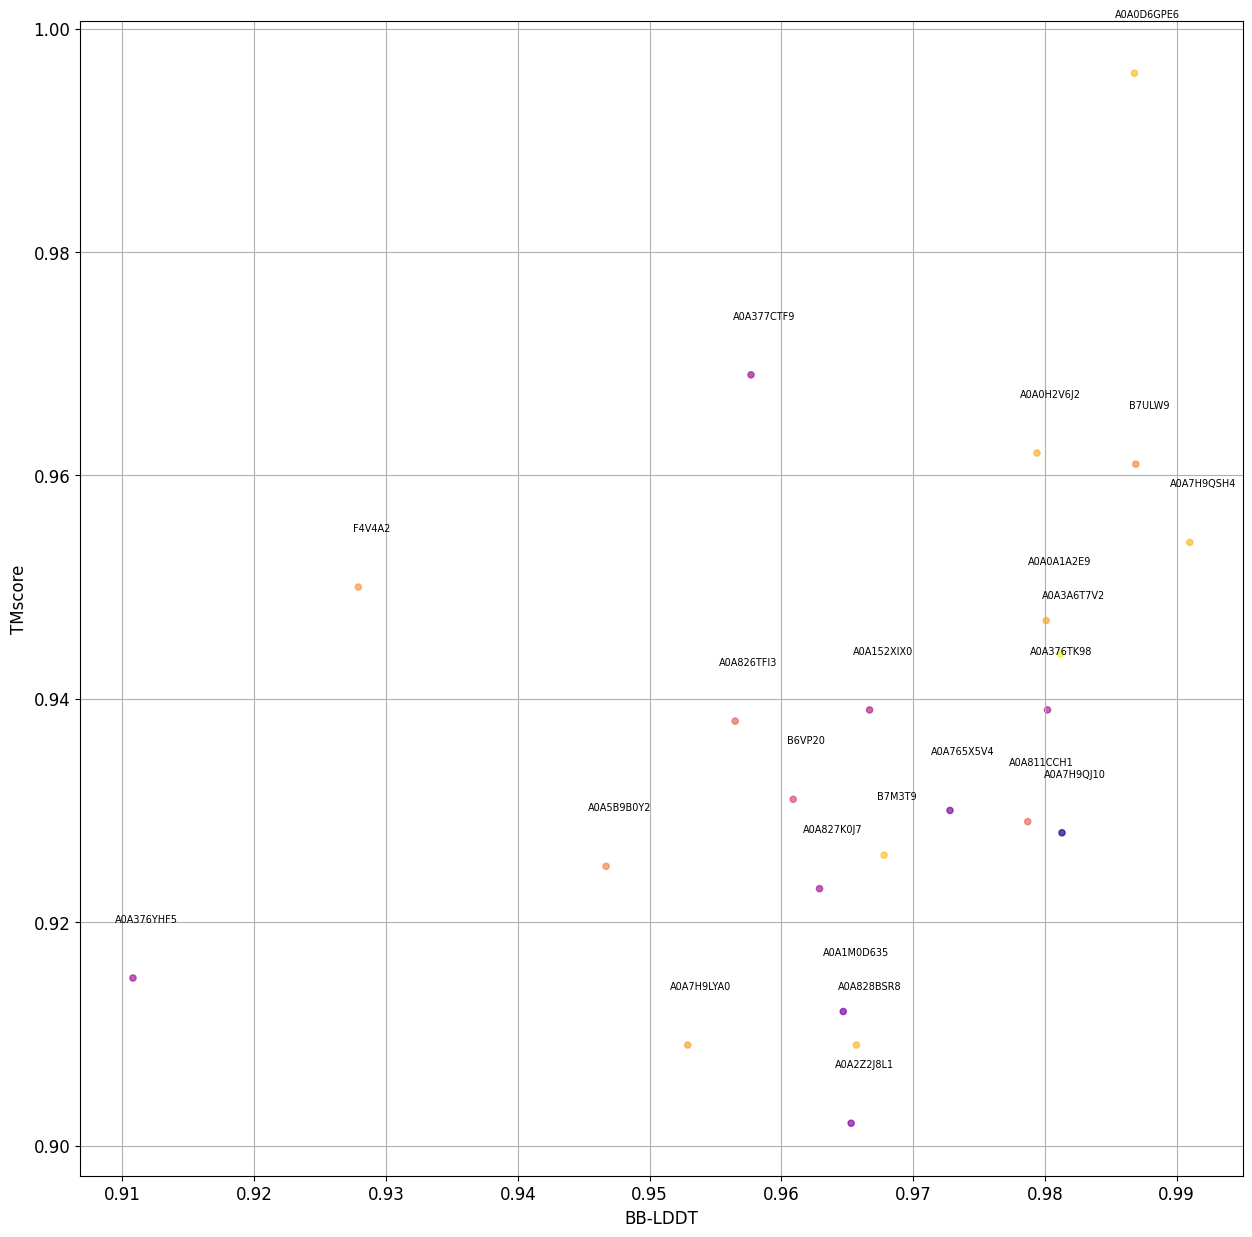

In [73]:
import matplotlib.pyplot as plt
import numpy as np

zoomed_df = tmp_df[(tmp_df["TMscore"] > 0.9) & (tmp_df["BB-LDDT"]>0.9)]
# Create a scatter plot
plt.figure(figsize=(15, 15))
plt.scatter(zoomed_df['TMscore'], zoomed_df['BB-LDDT'], c=zoomed_df['Matching Percentage'], alpha=0.7, cmap='plasma',s=20)

# Label each point with the corresponding ID
for i, row in zoomed_df.iterrows():
  plt.text(row['TMscore']+0.001,row['BB-LDDT']+0.005, row['ID'], fontsize=7, ha='center')

# Add labels and title
plt.xlabel('BB-LDDT')
plt.ylabel('TMscore')
# plt.xlim([70,90])
# plt.ylim([0.42,1])
# Show the plot
plt.grid(True)
plt.show()

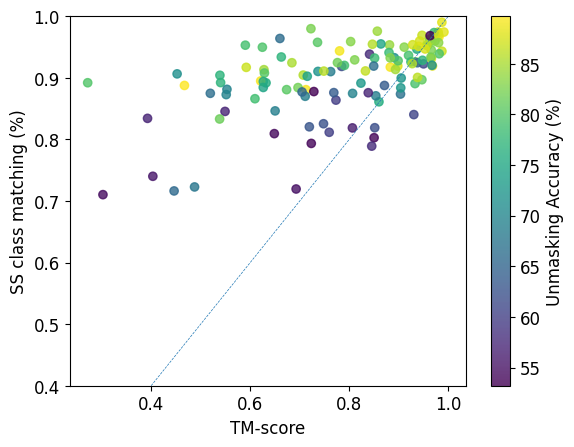

In [13]:
SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.plot([0.4,1], [0.4,1], linewidth=0.5, linestyle='--')
plt.scatter(tmp_df['TMscore'], tmp_df['ss2 %']/100, c=tmp_df['Matching Percentage'], alpha=0.8)
plt.colorbar(label="Unmasking Accuracy (%)")
plt.xlabel("TM-score")
plt.ylabel("SS class matching (%)")
plt.ylim([.4,1])
plt.show()

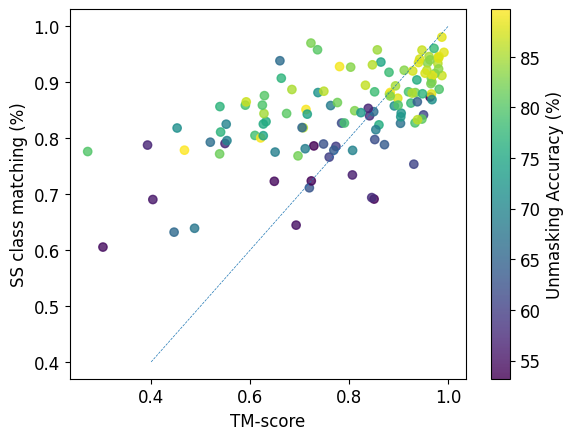

In [57]:
SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.plot([0.4,1], [0.4,1], linewidth=0.5, linestyle='--')
plt.scatter(tmp_df['TMscore'], tmp_df['ss1 %']/100, c=tmp_df['Matching Percentage'], alpha=0.8)
plt.colorbar(label="Unmasking Accuracy (%)")
plt.xlabel("TM-score")
plt.ylabel("SS class matching (%)")
# plt.ylim([.4,1])
plt.show()

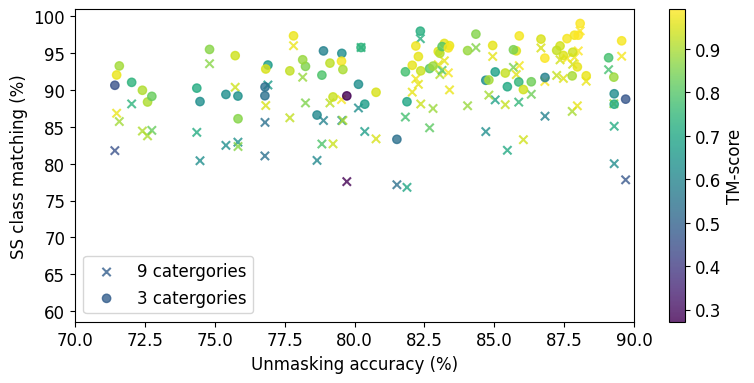

In [15]:
SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# plt.plot([0.4,1], [0.4,1], linewidth=0.5, linestyle='--')
plt.figure(figsize=(8,4))
plt.scatter( tmp_df['Matching Percentage'],tmp_df['ss1 %'], c=tmp_df['TMscore'], alpha=0.8, marker='x', label="9 catergories")
plt.scatter( tmp_df['Matching Percentage'],tmp_df['ss2 %'], c=tmp_df['TMscore'], alpha=0.8, marker='o', label="3 catergories")

plt.colorbar(label="TM-score")
plt.legend()

plt.xlabel("Unmasking accuracy (%)")
plt.ylabel("SS class matching (%)")
plt.xlim([70,90])
plt.tight_layout()
plt.show()

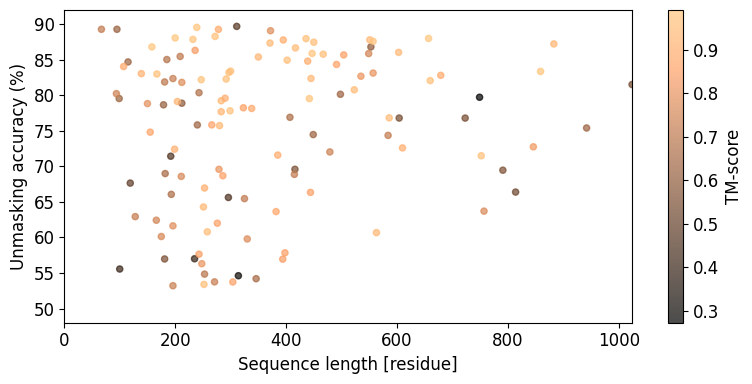

In [16]:
SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# plt.plot([0.4,1], [0.4,1], linewidth=0.5, linestyle='--')
plt.figure(figsize=(8,4))
plt.scatter( tmp_df['seq_length'], tmp_df['Matching Percentage'], c=tmp_df['TMscore'], alpha=0.7, marker='o', cmap='copper', s=20)

plt.colorbar(label="TM-score")
# plt.legend()

plt.ylabel("Unmasking accuracy (%)")
plt.xlabel("Sequence length [residue]")
plt.xlim([0,1024])
plt.ylim([48,92])
plt.tight_layout()
plt.show()

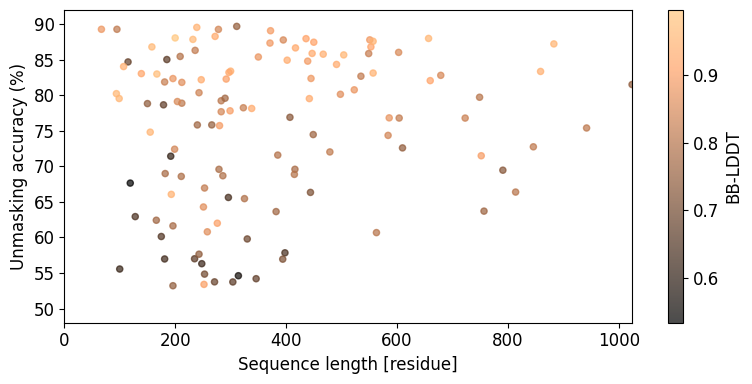

In [17]:
SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# plt.plot([0.4,1], [0.4,1], linewidth=0.5, linestyle='--')
plt.figure(figsize=(8,4))
plt.scatter( tmp_df['seq_length'], tmp_df['Matching Percentage'], c=tmp_df['BB-LDDT'], alpha=0.7, marker='o', cmap='copper', s=20)

plt.colorbar(label="BB-LDDT")
# plt.legend()

plt.ylabel("Unmasking accuracy (%)")
plt.xlabel("Sequence length [residue]")
plt.xlim([0,1024])
plt.ylim([48,92])
plt.tight_layout()
plt.show()

In [18]:
print("TM-score vs acc.: ", tmp_df['TMscore'].corr(tmp_df["Matching Percentage"]))
print("LDDT-score vs acc.: ", tmp_df['BB-LDDT'].corr(tmp_df["Matching Percentage"]))

TM-score vs acc.:  0.3236409459455816
LDDT-score vs acc.:  0.6554184362341307


In [19]:
print("ss1-score vs acc.: ", tmp_df['ss1 %'].corr(tmp_df["Matching Percentage"]))
print("ss2-score vs acc.: ", tmp_df['ss2 %'].corr(tmp_df["Matching Percentage"]))

ss1-score vs acc.:  0.6909138505955806
ss2-score vs acc.:  0.6658269766146054


In [20]:
print("ss1 vs BB-LDDT: ", tmp_df['ss1 %'].corr(tmp_df["BB-LDDT"]))
print("ss2 vs BB-LDDT: ", tmp_df['ss2 %'].corr(tmp_df["BB-LDDT"]))

ss1 vs BB-LDDT:  0.8345972099950668
ss2 vs BB-LDDT:  0.807385669686365


In [21]:
len(tmp_df)

124